In [6]:
from numpy.random import randn

class PosSensor1(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]


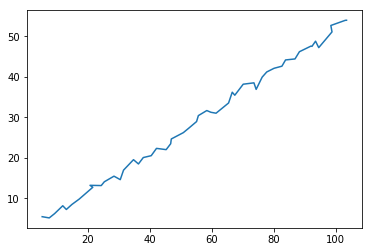

In [16]:
import matplotlib.pyplot as plt
import numpy as np

pos, vel = (4, 3), (2, 1)
sensor = PosSensor1(pos, vel, noise_std=1)
ps = np.array([sensor.read() for _ in range(50)])
plt.plot(ps[:,0],ps[:,1])
plt.show()

In [19]:
from filterpy.kalman import KalmanFilter
tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.   # time step 1 second

tracker.F = np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])

In [20]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[ 0.00025  0.0005   0.       0.     ]
 [ 0.0005   0.001    0.       0.     ]
 [ 0.       0.       0.00025  0.0005 ]
 [ 0.       0.       0.0005   0.001  ]]


In [21]:
tracker.H = np.array([[1, 0, 0,        0],
                      [0,        0, 1, 0]])

In [22]:


tracker.R = np.array([[5., 0],
                      [0, 5]])
tracker.R



array([[ 5.,  0.],
       [ 0.,  5.]])

In [23]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

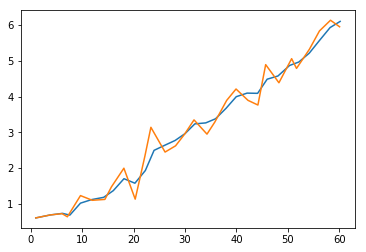

In [33]:
from filterpy.stats import plot_covariance_ellipse


R_std = 0.35
Q_std = 0.04

def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0   # time step

    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1, 0, 0, 0],
                          [0, 0, 1, 0]])

    tracker.R = np.eye(2) * R_std**2
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500.
    return tracker

# simulate robot movement
N = 30
sensor = PosSensor1((0, 0), (2, .2), noise_std=R_std)

zs = np.array([np.array([sensor.read()]).T for _ in range(N)])

# run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    #plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
    
plt.plot(mu[:,0],mu[:,2])
plt.plot(zs[:,0],zs[:,1])
plt.show()